<a href="https://colab.research.google.com/github/jtwang1027/cancer_omics/blob/master/2_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What features are criticial in determining phosphorylation?

---

Combining the transcript/prote-/phosph- omic dat + CNV

---



For this example, we'll example phosphorylation 'p.4EBP1' following 'EGF' treatment



In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import pandas as pd
import numpy as np
# from sklearn.metrics import mean_squared_error
# from math import sqrt
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans

import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

#xgboost
import xgboost
from xgboost import plot_importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics  import mean_squared_error


In [0]:
pho=pd.read_csv('/content/drive/My Drive/median_phospho_data.csv')
rna=pd.read_csv('/content/drive/My Drive/rnaseqexononly_marcotte.csv')
pro=pd.read_csv('/content/drive/My Drive/proteomics_consolidated.csv')

In [0]:
y=pho[(pho.treatment=='EGF') & (pho.time==60)]
pho=pho[pho.treatment=='full']

In [0]:
pho.head()

,cell_line,treatment,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
10,184A1,full,0.0,1.268450,3.011949,3.269844,2.971663,6.726300,3.876879,2.905013,3.089881,2.638730,3.617161,2.858352,0.604505,3.302806,2.194903,2.646986,2.819135,4.553402,1.771215,1.692169,2.281269,3.127042,2.810421,4.230595,2.957352,2.187180,1.630915,3.156479,2.841768,2.428991,6.638407,6.080130,2.677548,2.477925,2.320824,2.887623,1.565863,2.264294
49,184B5,full,0.0,0.644142,2.724148,1.992426,2.214774,6.145829,2.379644,2.210643,2.981967,2.273421,3.431763,3.004700,0.368793,2.988884,1.944248,2.060733,2.958852,4.589334,1.598929,1.356727,1.794975,3.041178,2.540606,4.159745,2.720892,2.324038,1.629922,2.703306,2.187006,1.896927,5.049717,4.743696,2.058578,2.113998,2.192451,2.412290,1.562300,2.227544
81,AU565,full,0.0,0.677910,1.779176,1.673790,1.759997,6.159892,3.368162,2.533022,NaN,2.116985,2.549938,2.684198,1.163269,NaN,1.567051,3.416434,2.420282,NaN,1.455397,1.582493,1.981800,2.817015,2.083279,3.484602,3.238661,1.740349,3.613720,4.152506,1.040180,NaN,5.587673,NaN,2.531707,1.647424,1.839102,2.551210,1.107368,2.433133
120,BT20,full,0.0,0.981176,2.298729,2.604696,2.357667,6.357916,3.449260,2.922381,4.431486,2.584877,3.362523,2.697081,1.161337,3.834566,2.659944,4.488377,2.644636,4.628266,1.624785,1.846577,2.502745,3.074615,1.866457,4.516338,3.021023,3.103188,2.332574,3.965937,1.474105,3.124887,6.637675,6.917825,2.257894,2.179263,2.762720,3.184696,2.611055,3.028543
159,BT474,full,0.0,1.063666,2.434756,1.759334,3.102078,6.121343,2.168054,2.905236,4.173112,2.802465,2.508447,2.819089,0.679170,3.155835,2.058977,4.332103,2.362265,5.009428,1.897446,1.531720,2.660783,2.502571,1.692339,3.748191,3.173929,1.724056,1.890721,2.842842,2.185061,2.172251,4.202805,6.846955,2.035517,1.780411,2.359247,3.278507,1.167880,2.727995


In [0]:
# rna.columns
rna.drop(['X', 'Unnamed: 0'],axis=1, inplace=True)

In [0]:
rna.head()

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL3,AADAT,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,...,PRG4,PSMA1,PSMA2,RBL1,RNASE11,RPP14,SDHD,SEPT1,SHPK,SLC25A10,SLC5A3,SNURF,SOGA3,SOX7,SRSF8,TAP2,TEC,TIMM10B,TLR9,TM4SF19,TM9SF1,TMBIM4,TMEM236,TMEM239,TMEM249,TUBB3,UGT2A1,UQCR11,ZFP41,ZMYM6,ZNF177,ZNF223,ZNF286A,ZNF33B,ZNF668,ZNF709,ZNF747,ZNF763,ZNF8,cell_line
0,-3.113,-2.914,5.767,2.394,4.522,3.376,-3.322,-3.322,1.062,5.507,2.602,4.955,5.779,-3.322,4.218,-0.078,5.011,0.941,4.076,2.924,5.637,0.373,4.920,-3.322,3.831,-1.440,-0.967,4.750,0.032,1.889,-2.376,0.511,3.796,-2.819,0.822,-3.322,-2.037,-3.322,3.492,-3.031,...,-0.578,7.182,6.709,1.932,-3.322,3.981,6.630,-2.400,1.775,0.561,3.281,5.371,-3.322,-0.604,4.236,3.121,-0.150,4.024,-3.322,-2.747,5.407,6.181,-3.322,-3.322,-3.322,2.599,-3.078,6.490,1.524,3.589,-1.207,0.553,3.622,2.744,1.727,-0.929,1.649,-2.487,0.376,184A1
1,2.298,-3.322,4.692,1.099,4.547,3.635,-3.322,-3.322,1.461,4.232,3.217,3.784,5.704,-3.322,4.154,-0.010,6.662,2.790,4.787,2.841,3.370,1.667,4.622,-1.332,1.452,-0.728,-0.197,5.781,-3.322,2.818,-1.792,-3.322,3.434,-0.491,0.562,-3.322,-2.067,-3.322,3.667,-3.322,...,-3.322,6.681,6.369,1.472,-3.322,3.690,5.057,-1.711,1.750,2.066,0.575,5.404,-3.322,3.097,3.717,4.738,-0.666,3.982,-3.087,0.447,4.810,5.796,-3.322,-3.322,-2.866,2.781,-3.322,6.749,1.111,3.450,-1.983,0.172,4.215,3.622,-0.347,-2.281,0.554,-3.322,2.173,184B5
2,-0.131,5.612,-2.902,0.193,4.643,4.838,-0.926,-3.322,1.350,4.661,1.310,6.112,5.910,-3.322,3.806,1.219,4.798,1.806,4.878,1.951,2.975,0.475,4.932,1.691,3.763,-0.520,-1.930,-3.322,-3.322,3.902,3.128,-1.423,1.454,-2.983,0.934,-3.322,-3.322,-3.322,4.256,-3.322,...,-3.322,7.126,6.474,2.518,-3.322,3.964,4.671,-1.080,2.158,4.165,1.200,5.282,-3.322,-3.322,1.838,2.723,0.450,4.016,-3.322,-3.322,5.743,5.516,-3.322,-3.322,-3.322,1.257,-3.322,6.769,2.016,2.746,-0.602,1.001,2.590,2.448,-0.505,-0.645,1.322,0.684,2.380,MPE600
3,0.423,-0.488,3.008,0.021,5.010,4.867,-1.982,-3.322,0.796,4.280,2.625,3.699,6.629,-3.322,5.004,2.574,4.835,2.249,3.647,2.683,4.590,-2.624,4.133,-3.322,-0.391,-1.927,-3.322,3.166,2.687,3.767,2.778,-0.383,2.387,-3.322,0.603,-3.322,-3.322,-3.322,3.269,-3.322,...,-3.322,7.252,7.308,3.403,-3.322,3.598,6.555,-3.322,3.677,5.147,2.231,1.667,-3.322,-2.801,3.769,4.569,0.111,4.141,-3.322,-3.322,5.994,5.976,-3.322,-3.322,-3.081,1.034,-3.322,5.970,-0.425,2.502,-3.322,0.095,3.073,2.245,2.341,-3.322,-0.101,-3.322,0.728,AU565
4,0.904,-3.322,-0.715,-1.611,4.365,4.156,-3.322,-3.322,-3.322,6.153,0.828,4.539,5.762,-3.322,4.430,-0.580,6.624,2.503,3.954,1.590,4.026,-0.633,5.812,-3.202,3.524,-1.601,-3.322,1.401,-3.322,3.588,-0.564,-0.427,-0.526,-3.322,2.150,-3.322,-3.322,-3.322,2.013,-3.322,...,-3.322,7.727,7.601,2.627,-3.322,3.390,6.260,-2.257,2.968,4.093,-3.322,-2.224,-3.322,-3.322,2.901,4.307,1.773,4.112,-3.322,2.193,4.683,5.302,-3.322,-3.322,-3.019,2.985,-3.322,7.257,0.977,1.018,0.913,1.496,3.496,2.199,0.332,-0.733,2.143,-0.296,1.167,BT20


In [0]:
pro.rename(columns={ 'Unnamed: 0':'cell_line'}, inplace=True)

In [0]:
pro.head()

,cell_line,A0A024RBG1,A0A087WUL8;P0DPF2;P0DPF3;Q3BBV2;Q6P3W6;Q8N660,A0A087X1C5;P10635,A0A096LP01,A0A0A6YYK6,A0A0B4J2D5;P0DPI2,A0A0B4J2F0,A0A0U1RR11;A0A0U1RRI6;P0DPI3,A0A0U1RRL7,A0A1B0GU71,A0AV02,A0AV96,A0AVT1,A0FGR8,A0JLT2,A0JNW5,A0MZ66,A0PJW6,A1A4S6,A1A5D9,A1KZ92,A1L020,A1L0T0,A1L170,A1L390,A1X283,A2RRP1,A2RUC4,A2VCL2,A3KMH1,A3KN83,A4D1E9,A4D1F6,A4D1P6,A4D1S0,A4D1S5,A5A3E0,A5D8V6,A5D8V7,...,Q9Y6G3,Q9Y6G5,Q9Y6G9,Q9Y6H1,Q9Y6H3,Q9Y6I3,Q9Y6I4,Q9Y6I8,Q9Y6I9,Q9Y6J9,Q9Y6K0,Q9Y6K1,Q9Y6K5,Q9Y6K8,Q9Y6K9,Q9Y6M1,Q9Y6M5,Q9Y6M7,Q9Y6M9,Q9Y6N1,Q9Y6N3,Q9Y6N5,Q9Y6N7,Q9Y6P5,Q9Y6Q5,Q9Y6R0,Q9Y6R4,Q9Y6T7,Q9Y6U3,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X2,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,MCF12A,0.0,0.0,0.0,-0.049267,0.000000,0.0,0.0,0.0,0.483507,0.086852,0.000000,-1.487639,-0.025162,0.485327,0.000000,0.000000,-1.135593,0.000000,-1.086574,0.0,-2.230968,0.000000,-1.332238,0.0,0.342369,0.560528,-0.574949,0.0,-2.509035,-0.412571,-0.821375,-0.355927,-0.665002,-0.488274,0.000000,-1.158968,0.000000,-0.556083,-0.613953,...,0.123961,0.051939,-0.229200,-0.239376,0.0,-0.462240,-0.648122,-3.721863,-0.094161,0.000000,0.173746,0.000000,-0.646602,0.0,0.134953,-0.196679,0.875858,-0.669411,0.165229,0.000000,-0.682805,0.839595,-0.121163,-1.306469,-0.967691,0.209331,-0.696071,0.308007,0.000000,-1.889580,-0.899191,0.301509,0.000000,-1.201301,-0.970549,0.0,-1.851081,-1.580570,-0.865814,0.003284
1,AU565,0.0,0.0,0.0,0.898216,-0.985849,0.0,0.0,0.0,0.150228,0.000000,0.000000,0.620711,-0.574947,-0.311711,0.000000,0.575404,1.357909,-1.778015,1.499091,0.0,0.895473,0.000000,0.964167,0.0,0.000000,-2.118251,-0.491312,0.0,0.000000,1.072634,-0.343047,0.303514,-0.451623,1.029040,-0.355470,1.133781,0.129086,0.172786,-0.090155,...,-0.748592,-0.545416,-0.071728,-0.584842,0.0,-0.206579,0.276719,2.363464,0.757839,-0.427766,-0.958593,-1.398265,0.069877,0.0,0.000000,0.000000,-0.508876,-0.570975,1.108220,-0.804275,0.081275,-1.285153,0.000000,0.000000,-0.490754,-0.097471,0.147986,0.000000,-4.071137,-0.855461,-0.280771,-0.605034,0.000000,0.090331,-0.084732,0.0,1.133150,0.340540,-1.071741,-0.205565
2,HCC1954,0.0,0.0,0.0,0.000000,-0.868302,0.0,0.0,0.0,-1.398618,-0.265187,0.000000,0.811323,0.405803,0.095134,-0.142155,0.000000,0.060257,-4.124408,0.000000,0.0,-0.445860,0.000000,-0.709515,0.0,0.307338,-0.123956,-0.899110,0.0,-2.239892,-0.953364,0.093493,-0.883459,0.899015,-0.556004,0.000000,-0.157332,0.000000,-0.363604,0.412309,...,-0.206874,-0.154476,-0.172175,0.044887,0.0,0.548246,-0.271768,0.000000,-0.506942,-0.415911,-0.269677,0.000000,0.941183,0.0,0.503473,-0.387935,-0.602299,-0.124295,-0.718702,-0.747458,-0.827176,0.530013,0.000000,0.000000,-0.440230,-0.093695,-0.708874,0.000000,0.000000,-2.491809,0.117394,-0.087318,0.000000,0.035589,0.481313,0.0,0.330495,-0.077987,-0.645387,-0.801501
3,OCUBM,0.0,0.0,0.0,-1.279137,-1.215071,0.0,0.0,0.0,-1.219686,0.459439,-0.357439,1.346222,0.193913,-0.292781,0.000000,0.727720,0.622312,1.106754,0.000000,0.0,0.047715,-1.550935,-0.070720,0.0,0.000000,-0.629159,-0.581517,0.0,0.000000,-0.286262,0.194860,0.853990,0.000000,1.644987,-0.340547,0.443267,-0.441699,-0.225225,-0.457929,...,0.148760,0.044830,-0.337781,-0.194756,0.0,-0.568503,0.818158,0.000000,0.093419,-0.674923,-1.404674,0.795436,-1.964782,0.0,-0.268656,0.000000,-1.396207,-1.321029,-0.004667,-0.738751,0.581342,-0.420048,0.000000,1.544920,-0.111734,0.000000,-0.019355,0.000000,0.000000,-0.993605,0.174562,-0.087074,0.000000,0.684258,0.000000,0.0,0.000000,0.066163,-1.676465,-0.983287
4,HCC1187,0.0,0.0,0.0,-0.353971,0.000000,0.0,0.0,0.0,-0.395183,-0.031582,0.000000,-2.680162,0.234843,-0.613488,0.000000,0.000000,-0.644168,0.000000,0.000000,0.0,-0.321961,1.437162,0.036495,0.0,0.000000,1.858171,1.837362,0.0,-2.487348,0.273965,-0.302122,0.222538,0.000000,0.818767,-2.000083,0.000000,-1.318872,0.577577,-1.047995,...,0.000000,-0.823257,0.265769,-0.639329,0.0,1.162066,-0.162388,0.000000,-0.814866,0.304525,0.000000,0.778202,1.154064,0.0,-0.394202,-4.641084,0.016719,-1.777071,-0.747793,0.000000,1.305643,-1.890484,0.00

combining phosphorylation, protein, and transcript data

In [0]:
total=pd.merge(pro,rna,on='cell_line', how='inner')
total=pd.merge(total,pho,on='cell_line', how='inner')

In [0]:
quant=total.dtypes=='float64' # quantitative columns

In [0]:
total.loc[:,quant]

,A0A024RBG1,A0A087WUL8;P0DPF2;P0DPF3;Q3BBV2;Q6P3W6;Q8N660,A0A087X1C5;P10635,A0A096LP01,A0A0A6YYK6,A0A0B4J2D5;P0DPI2,A0A0B4J2F0,A0A0U1RR11;A0A0U1RRI6;P0DPI3,A0A0U1RRL7,A0A1B0GU71,A0AV02,A0AV96,A0AVT1,A0FGR8,A0JLT2,A0JNW5,A0MZ66,A0PJW6,A1A4S6,A1A5D9,A1KZ92,A1L020,A1L0T0,A1L170,A1L390,A1X283,A2RRP1,A2RUC4,A2VCL2,A3KMH1,A3KN83,A4D1E9,A4D1F6,A4D1P6,A4D1S0,A4D1S5,A5A3E0,A5D8V6,A5D8V7,A5PLL7,...,ZNF763,ZNF8,time,b.CATENIN,cleavedCas,CyclinB,GAPDH_y,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
0,0.0,0.0,0.0,-0.049267,0.000000,0.0,0.000000,0.0,0.483507,0.086852,0.000000,-1.487639,-0.025162,0.485327,0.000000,0.000000,-1.135593,0.000000,-1.086574,0.0,-2.230968,0.000000,-1.332238,0.0,0.342369,0.560528,-0.574949,0.000000,-2.509035,-0.412571,-0.821375,-0.355927,-0.665002,-0.488274,0.000000,-1.158968,0.000000,-0.556083,-0.613953,0.621727,...,-3.269,1.802,0.0,0.796624,3.634414,4.259170,2.948525,8.938261,4.328501,3.060110,3.662150,2.895975,3.537257,3.893305,0.386814,2.448781,2.229028,3.745847,3.034396,NaN,2.565037,2.008700,2.274048,3.322565,3.360238,4.416692,3.672516,2.362774,2.204912,3.126724,2.133127,2.237642,6.930361,6.697572,2.383709,2.695585,2.723412,4.091257,2.170265,2.536197
1,0.0,0.0,0.0,0.898216,-0.985849,0.0,0.000000,0.0,0.150228,0.000000,0.000000,0.620711,-0.574947,-0.311711,0.000000,0.575404,1.357909,-1.778015,1.499091,0.0,0.895473,0.000000,0.964167,0.0,0.000000,-2.118251,-0.491312,0.000000,0.000000,1.072634,-0.343047,0.303514,-0.451623,1.029040,-0.355470,1.133781,0.129086,0.172786,-0.090155,0.000000,...,-3.322,0.728,0.0,0.677910,1.779176,1.673790,1.759997,6.159892,3.368162,2.533022,NaN,2.116985,2.549938,2.684198,1.163269,NaN,1.567051,3.416434,2.420282,NaN,1.455397,1.582493,1.981800,2.817015,2.083279,3.484602,3.238661,1.740349,3.613720,4.152506,1.040180,NaN,5.587673,NaN,2.531707,1.647424,1.839102,2.551210,1.107368,2.433133
2,0.0,0.0,0.0,0.000000,-0.868302,0.0,0.000000,0.0,-1.398618,-0.265187,0.000000,0.811323,0.405803,0.095134,-0.142155,0.000000,0.060257,-4.124408,0.000000,0.0,-0.445860,0.000000,-0.709515,0.0,0.307338,-0.123956,-0.899110,0.000000,-2.239892,-0.953364,0.093493,-0.883459,0.899015,-0.556004,0.000000,-0.157332,0.000000,-0.363604,0.412309,0.000000,...,-0.305,0.642,0.0,0.374728,1.273206,2.553170,1.695417,7.650303,3.112449,1.040650,4.469130,2.709959,3.224827,3.150891,0.969146,3.639952,2.342502,3.727242,2.282022,5.744429,1.699212,1.403599,1.820592,2.730297,1.823107,3.928486,2.881825,3.077154,1.878078,4.912476,0.757156,NaN,6.332559,7.209900,2.113729,1.751811,2.828594,2.867869,2.863960,2.937390
3,0.0,0.0,0.0,-1.279137,-1.215071,0.0,0.000000,0.0,-1.219686,0.459439,-0.357439,1.346222,0.193913,-0.292781,0.000000,0.727720,0.622312,1.106754,0.000000,0.0,0.047715,-1.550935,-0.070720,0.0,0.000000,-0.629159,-0.581517,0.000000,0.000000,-0.286262,0.194860,0.853990,0.000000,1.644987,-0.340547,0.443267,-0.441699,-0.225225,-0.457929,-1.548848,...,-1.532,2.452,0.0,0.908969,2.076346,2.206307,2.998360,6.139443,3.423366,3.410906,4.880119,2.305337,3.608125,3.092173,0.813432,2.548828,2.228816,4.067699,2.107084,4.713693,1.421559,1.707575,2.365095,2.752756,1.729998,3.584500,3.179606,2.373251,4.071503,3.162771,1.993288,2.795763,3.162941,7.085730,2.337749,2.019526,2.667611,3.101973,1.239870,2.592606
4,0.0,0.0,0.0,-0.353971,0.000000,0.0,0.000000,0.0,-0.395183,-0.031582,0.000000,-2.680162,0.234843,-0.613488,0.000000,0.000000,-0.644168,0.000000,0.000000,0.0,-0.321961,1.437162,0.036495,0.0,0.000000,1.858171,1.837362,0.000000,-2.487348,0.273965,-0.302122,0.222538,0.000000,0.818767,-2.000083,0.000000,-1.318872,0.577577,-1.047995,0.000000,...,-2.126,3.201,0.0,0.796624,2.288225,2.913281,2.880842,6.074161,4.235507,3.074160,4.379196,2.918387,3.386415,3.620821,0.800157,3.053267,2.707340,3.808182,2.238698,NaN,2.215171,1.864086,2.244042,2.470527,3.350142,3.38078

In [0]:
total.loc[:,quant]= MinMaxScaler().fit_transform(total.loc[:,quant])

In [0]:
total.dropna(axis=1,inplace=True)

In [0]:
y

,cell_line,treatment,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,p.Akt.Ser473.,p.AKT.Thr308.,p.AMPK,p.BTK,p.CREB,p.ERK,p.FAK,p.GSK3b,p.H3,p.HER2,p.JNK,p.MAP2K3,p.MAPKAPK2,p.MEK,p.MKK3.MKK6,p.MKK4,p.NFkB,p.p38,p.p53,p.p90RSK,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
9,184A1,EGF,60.0,1.387644,2.380511,1.687352,3.019043,4.945261,1.971002,1.038883,2.299306,2.566744,3.451464,2.511451,0.477254,2.902384,1.931954,1.558872,4.752701,4.584944,2.083049,1.346200,1.805584,2.337472,2.119401,3.600856,2.321230,1.955401,1.415363,2.832417,2.403166,2.149662,5.107865,5.092896,1.989772,2.374451,1.800993,2.326742,2.433128,2.277509
48,184B5,EGF,60.0,0.701472,2.624060,1.559331,2.123604,5.836948,1.711272,2.078841,2.951335,2.200617,3.402234,2.836053,0.458253,2.673386,2.030302,1.839076,4.194177,4.704451,1.678014,1.343445,1.838409,2.918577,2.412224,3.842308,2.828036,2.428187,1.677360,2.643007,2.039500,2.278217,4.408503,5.250961,2.076611,2.056812,2.253833,2.594247,2.246455,2.739950
80,AU565,EGF,60.0,0.612624,1.606909,1.691062,1.896838,5.637191,3.057995,2.028169,NaN,2.172047,2.832928,2.697991,1.442841,NaN,1.952234,3.870384,3.435501,NaN,2.317428,1.622814,2.645934,3.372703,2.285538,4.734593,3.525845,2.908163,3.635976,5.214433,1.167030,NaN,3.876109,NaN,3.081120,1.643218,2.078699,3.132313,1.393637,3.419103
119,BT20,EGF,60.0,0.934534,2.246159,2.093256,2.448518,5.764426,2.557062,2.544115,4.701265,2.573458,3.420240,2.552222,1.551837,3.996405,2.678773,4.349992,3.255163,5.761866,2.124337,1.852183,2.845421,3.221769,2.034531,4.688123,3.177132,3.097863,2.448747,4.618962,1.381803,3.773417,3.423361,7.387691,2.528369,2.073428,2.700776,3.858893,1.927362,3.060014
158,BT474,EGF,60.0,0.939968,2.304067,1.608099,2.820131,5.742485,1.938516,2.424600,3.797367,2.550643,2.693943,2.615033,0.939538,3.052084,1.951432,3.949399,2.797792,4.736008,2.006449,1.464213,2.791771,2.470646,1.534034,3.367656,3.105729,1.915132,1.911112,2.763102,2.092404,1.853996,3.275360,6.654130,2.136761,1.720291,2.457390,3.401249,1.086139,2.717389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,UACC3199,EGF,60.0,1.199082,2.443006,2.554975,3.823914,5.771385,2.665864,3.363005,3.267202,2.130910,4.161245,3.242617,1.751150,4.303416,2.332270,3.903431,3.879398,4.625863,2.060934,2.222566,3.063075,3.291862,3.138306,4.525420,3.453113,3.421351,2.365094,5.319678,2.450738,2.688739,3.143051,7.221389,3.131762,2.411563,3.056178,4.316219,1.682352,2.937610
2198,UACC812,EGF,60.0,0.399391,1.764851,1.890634,2.119715,6.178147,2.751361,1.900655,2.983383,1.790630,2.705035,2.748413,0.342840,3.031074,1.745424,2.888134,2.287760,4.569699,1.423482,1.152346,1.603004,2.763876,1.470048,3.893741,2.282785,2.181079,1.636334,3.815976,1.509907,2.479591,4.448161,6.199380,1.509564,1.203784,2.422954,2.329048,2.115560,2.749544
2237,UACC893,EGF,60.0,0.796624,2.076336,2.389964,2.794916,5.945774,3.660803,3.620972,2.787077,2.363063,3.071628,2.788999,1.521841,3.077960,1.515802,3.351459,2.670622,NaN,1.821553,1.579795,2.868688,2.244927,1.698443,3.417652,2.801203,1.332942,2.286077,2.293383,1.799698,1.412349,5.203555,7.023974,1.852964,1.618734,0.976659,2.117997,1.011167,2.013081
2276,ZR751,EGF,60.0,0.586330,2.074044,2.123000,2.405852,5.358636,2.696695,2.576486,3.326815,2.264373,2.574343,2.961846,2.616395,2.954961,2.153888,3.321341,3.036919,4.303942,1.926860,1.487881,2.359489,2.530166,1.395184,2.884295,2.890415,2.000497,2.305052,3.675716,1.647315,3.411993,3.174712,7.088838,2.086124,1.463195,3.220708,2.993838,2.051491,2.779334


In [0]:
total=total[:-2]

In [0]:
y=y['p.4EBP1']

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(total.loc[:,quant],y,test_size = 0.25, random_state=1234)

In [0]:
elastic= ElasticNet(random_state=0, normalize=True)
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)


In [0]:
# elastic.fit(total.loc[:,quant], y)
search.fit(X_train, y_train)

In [0]:
search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
pred=search.predict(X_test)
sqrt(mean_squared_error(pred,y_test))

0.6630850169739286

In [0]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [0]:
mean_squared_error( model.predict(X_test), y_test)

0.458409435227497

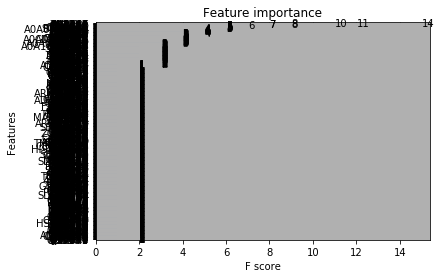

In [0]:
# plt.bar(range(len(best_xgb_model.feature_importances_)), best_xgb_model.feature_importances_)
plot_importance(model)

In [0]:
best_xgb_model.
best_xgb_model.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

AttributeError: ignored

In [0]:
order=np.argsort(model.feature_importances_)

In [0]:
model.feature_importances_[order[::-1]]

array([0.05946947, 0.05536789, 0.05505547, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [0]:
X_train.columns[order[-15:]]

Index(['O60291', 'ANKRD11', 'Q709F0', 'EPS8', 'TAC3', 'Q12933', 'P42345',
       'C9orf64', 'C1orf216', 'GYG2', 'HYLS1', 'Q9P0U1', 'Q9BZG1', 'Q12873',
       'Q5U5X0'],
      dtype='object')

In [0]:
model.feature_importances_[order[-15:]]

array([0.01911655, 0.02065211, 0.02346093, 0.02489898, 0.02728213,
       0.03006143, 0.03109837, 0.03142227, 0.03267387, 0.03488638,
       0.0415624 , 0.04546992, 0.05505547, 0.05536789, 0.05946947],
      dtype=float32)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

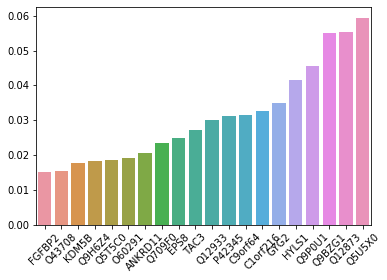

In [0]:
g=sns.barplot(x=X_train.columns[order[-20:]] ,y=model.feature_importances_[order[-20:]])
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45)

In [0]:
#random forests

In [0]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [0]:
regr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
order2=np.argsort(regr.feature_importances_)
regr.feature_importances_[order2[-15:]]

array([0.02821994, 0.02877051, 0.02893723, 0.03664031, 0.04665487,
       0.05740081, 0.06440635, 0.06460794, 0.06515121, 0.06613955,
       0.06725088, 0.06737328, 0.06778418, 0.06978235, 0.07292188])

In [0]:
mean_squared_error( regr.predict(X_test), y_test)

0.5247761194620923

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

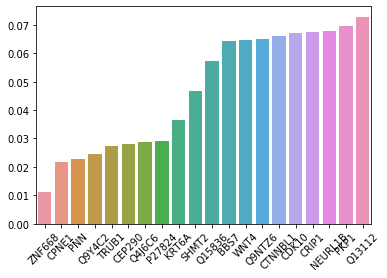

In [0]:
g=sns.barplot(x=X_train.columns[order2[-20:]] ,y=regr.feature_importances_[order2[-20:]])
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45)

TypeError: ignored